# Bros? 

But we're going to stick with parrots. 

![](https://i.pinimg.com/originals/f1/3c/09/f13c094d1190749954431e39409e09cf.jpg)

In [1]:
import numpy as np
from SpringRank import SpringRank
# from itertools import chain
import matplotlib.pyplot as plt
from py import estimation
import pandas as pd
%matplotlib inline

In [2]:
M = np.loadtxt('data/newcomb_frat/frat_no_meta.txt')

In [3]:
M.shape

weeks = np.concatenate((np.arange(0,9), np.arange(10, 16)))
n = 17
n_weeks = len(weeks)
n_weeks

15

The next step is to transform the data into a sequence of cumulative hiring matrices. 

In [4]:
t_min = 0

T_ = np.zeros((n_weeks, n, n))

for i in range(M.shape[0]):
    t = int(i/n)
    dude = i%n
    T_[t, :, dude] = (M[i] <= 5)

# for i in df.index:
#     T_[df['study.quarter'][i] - 1, lookup[df.actor[i]], lookup[df.target[i]]] += df['number.wins'][i] 
T = np.cumsum(T_, axis = 0)

In order to set the initial condition, we'll start with 20 years of data and plug all that into the initial hiring matrix, then normalize. This is to help remove artifacts at the very beginning of the time-series. 

In [5]:
# Let's start t_start years in
t_start = 0
A0 = T[t_start,:,:]
A0 = A0 / A0.sum() # normalized

# mean hiring per year after t_start: 
v = T[t_start:,:,:].sum(axis = (1,2))
A0 = A0*((v[-1] - v[0]) / len(v))

Next, we'll try to learn the parameters from the data. 

In [9]:
lam_grid = 201 # resolution in $\lambda$
b_grid = 201   # resolution in $\beta$

LAMBDA = np.linspace(0, 1, lam_grid) # lambda values at which to evaluate
BETA = np.linspace(0, 5, b_grid)            # beta values at which to evaluate

# compute the likelihood at each combination of lambda and beta. 
# might take a little while depending on lam_grid, beta_grid, n, and n_rounds

M = estimation.likelihood_surface(T, 
                                  LAMBDA, 
                                  BETA, 
                                  A0, 
                                  fun = SpringRank.SpringRank, 
                                  alpha = .0001) 

M_deg = estimation.likelihood_surface(T, 
                                      LAMBDA, 
                                      BETA, 
                                      A0, 
                                      fun = lambda A: A.sum(axis = 1))

M_uniform = estimation.likelihood_surface(T, 
                                      LAMBDA, 
                                      BETA, 
                                      A0, 
                                      fun = lambda A: np.ones(A.shape[0]))

for mat in [M, M_deg, M_uniform]:
    print(round(mat.max(), 3), estimation.get_estimates(mat, BETA, LAMBDA))
    
# these data support the SpringRank model over the straight degree model, albeit quite weakly. 

-3.129 {'beta': 1.55, 'lambda': 0.26}
-3.132 {'beta': 0.15000000000000002, 'lambda': 0.27}
-3.252 {'beta': 3.1, 'lambda': 0.0}


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: No contour levels were found within the data range.
  if sys.path[0] == '':


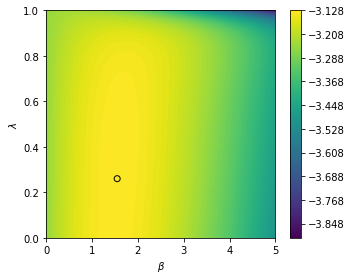

In [7]:
fig = plt.figure(figsize = (5,4))
ax = fig.add_subplot(111)

xg, yg = np.meshgrid(BETA, LAMBDA)

im = ax.contourf(xg, yg, M, levels = 100)
ax.contour(xg, yg, M, 
           levels = np.linspace(M.max()-50, 
                                M.max(), 10), 
           linewidths = .5, 
           colors = 'black', 
           linestyles = 'solid')

plt.colorbar(im)

ax.set(xlabel = r'$\beta$',
       ylabel = r'$\lambda$')

hat = estimation.get_estimates(M, BETA, LAMBDA)
beta_hat = hat['beta']
lambda_hat = hat['lambda']


ax.scatter(beta_hat, lambda_hat, color = 'black', facecolor = 'None')

plt.tight_layout()

In [8]:
# the estimates are: 
ix = np.where(M == M.max())
beta_hat = BETA[ix[1]][0]
lambda_hat = LAMBDA[ix[0]][0]
beta_hat, lambda_hat

(1.55, 0.26)

In [9]:
print('The max LL under the SpringRank model is ' + str(round(M.max())))
M0 = estimation.likelihood_surface(T, LAMBDA, BETA, A0, method = 'null') 
print('The max LL under the null model is ' + str(round(M0.max())))

The max LL under the SpringRank model is -3870.0
The max LL under the null model is -3874.0


# Time-Series Visualization

Now that we have plausible(??) values for $\lambda$ and $\beta$, we can visualize time-series of $\gamma$.

In [10]:
T_ = T[t_start:,:,:]

quarters = np.arange(t_start, 4) + 1
lam = lambda_hat
n_rounds = T_.shape[0]
beta = beta_hat

# def plot_gammas(T, lam, title = '', figsize = (5,4)):
A = estimation.state_matrix(T_, lam, A0) # check in on this state matrix computation, seems off
GAMMA = np.zeros((n_rounds, n))
for k in range(n_rounds):
    GAMMA[k] = estimation.compute_gamma(A[k], beta)
    
top_trajectories = np.unique(GAMMA.argmax(axis = 1))
top_trajectories = (-GAMMA.mean(axis = 0)).argsort()[0:6]

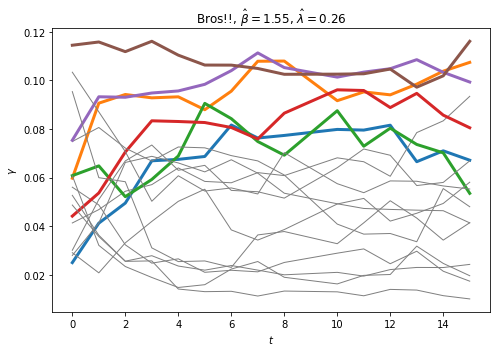

In [11]:
fig = plt.figure(figsize = (7,5))
ax = fig.add_subplot(111)

k = 0
for l in range(n):
    if l in top_trajectories: 
        ax.plot(weeks, GAMMA[:,l], alpha = 1, linewidth = 3)
        k += 1
    else:
        ax.plot(weeks, GAMMA[:,l], color = 'grey', alpha = 1, linewidth = 1)

        
    ax.set(xlabel = r'$t$',
       ylabel = r'$\gamma$', 
       title = r'Bros!!, $\hat{\beta} = $' + str(round(beta_hat, 2)) + r', $\hat{\lambda} = $' + str(round(lambda_hat, 2)))

# ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.1),
#           fancybox=False, shadow=False, ncol=3)

plt.tight_layout()

# Comparison of several measures

# A prettier version

The code below just takes these two plots and combines them into a single figure, with some cosmetics. 

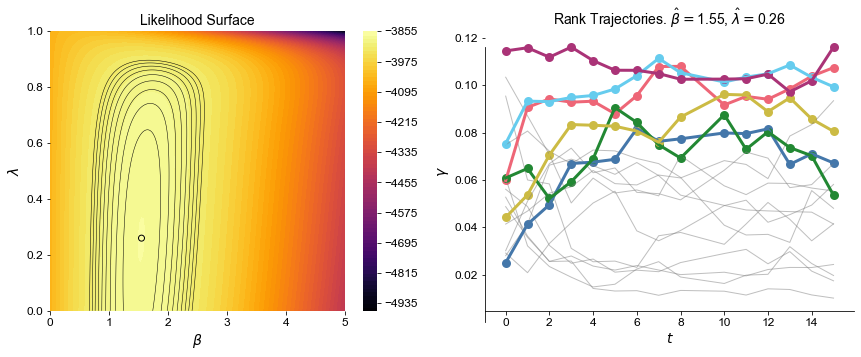

In [12]:
import matplotlib
matplotlib.rcParams['font.sans-serif'] = "Arial Unicode MS"

SMALL_SIZE = 8
MEDIUM_SIZE = 12
BIGGER_SIZE = 14

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=BIGGER_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=BIGGER_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=MEDIUM_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title


fig = plt.figure(figsize = (12,5))

ax1 = fig.add_subplot(121)
xg, yg = np.meshgrid(BETA, LAMBDA)

im = ax1.contourf(xg, yg, M, levels = 100, cmap = 'inferno')
ax1.contour(xg, yg, M, 
           levels = np.linspace(M.max()-50, 
                                M.max(), 10), 
           linewidths = .5, 
           colors = 'black', 
           linestyles = 'solid')

cb = plt.colorbar(im)
cb.outline.set_visible(False)

#     ax.scatter(beta, lam, color = 'black')

ax1.set(xlabel = r'$\beta$',
       ylabel = r'$\lambda$',
       title = 'Likelihood Surface')

ix = np.where(M == M.max())
beta_hat = BETA[ix[1]][0]
lambda_hat = LAMBDA[ix[0]][0]

ax1.scatter(beta_hat, lambda_hat, color = 'black', facecolor = 'None')

for pos in ['top', 'right', 'left', 'bottom']: 
    ax1.spines[pos].set_visible(False)

ax2 = fig.add_subplot(122)

cset = ['#4477AA', '#EE6677', '#228833', '#CCBB44', '#66CCEE', '#AA3377']

k = 0

for l in range(n):
    if l not in top_trajectories:
        ax2.plot(weeks, GAMMA[:,l], color = 'grey', alpha = .5, linewidth = 1)

for l in range(n):
    if l in top_trajectories: 
        ax2.plot(weeks, GAMMA[:,l], alpha = 1, linewidth = 3, 
                 color = cset[k])
        ax2.scatter(weeks, GAMMA[:,l], alpha = 1, linewidth = 3, 
         color = cset[k])
        
       
       
        
        
        k += 1
        
ax2.spines['top'].set_visible(False)
ax2.spines['right'].set_visible(False)
ax2.spines['left'].set_bounds(0, GAMMA.max())


ax2.set(xlabel = r'$t$',
       ylabel = r'$\gamma$', 
       title = r'Rank Trajectories. $\hat{\beta} = $' + str(round(beta_hat, 2)) + r', $\hat{\lambda} = $' + str(round(lambda_hat, 2)))

# ax2.legend(loc='upper center', bbox_to_anchor=(1.1, 0.7),
#           fancybox=False, shadow=False, ncol=1, frameon = False)

# fig.suptitle('Math PhD Exchange', fontsize = 16)

plt.tight_layout()

plt.savefig('fig/bros_.png', dpi = 300, bbox_inches = 'tight')

In [13]:
stderrs = np.sqrt(-np.diag(np.linalg.inv(estimation.hessian(M, BETA, LAMBDA)[ix])[0]))
stderrs

array([0.71814993, 0.01912222])

# Simulations

In [14]:
def simulate(n, beta, lam, n_rounds, method = 'stochastic', update_interval = 1, A0 = None):
    A = T[0] / T[0].sum()
    
    for r in range(n_rounds):          
        if r % update_interval == 0:                    # update the springranks at this interval
            gamma = estimation.compute_gamma(A, beta)
            
        GAMMA[r,:] = gamma                              # record current gamma
        A = lam*A + (1-lam)*estimation.increment(n, gamma, method) # update A
        
    return(GAMMA)

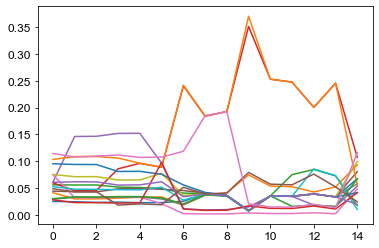

In [15]:
GAMMA = simulate(n, beta_hat, lambda_hat, t)
for i in range(n):
    plt.plot(GAMMA[:,i])